In [2]:
#!/usr/bin/env python3.7
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import timeit
from datetime import date
import seaborn as sns

import statsmodels.api as sm

from scipy import stats
import scipy as scipy

import svgutils.transform as sg
import sys

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)  # Give us all the columns without truncation    

In [3]:
def importCSV(filePath):
    dataFrame = pd.read_csv(filePath, header=0, low_memory=False)
    return dataFrame

def reIndex(DF):
    DF.reset_index(drop=True, inplace=True)
    return 0

def nullDrop(DF,col):
    return DF.dropna(subset=col)

def dfDrop(DF,col,inPlace):
    if(inPlace):
        DF.drop(col, inplace=True, axis=1)
        return 0
    else:
        return DF.drop(col,axis=1)

def makeDict(value,key):
    myDict = value
    myDict.index = key
    return myDict.to_dict()

In [14]:
####################################### Dataframes ##########################################################

paidGames = importCSV('data/processed/paidGames.csv')  #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days
freeGames = importCSV('data/processed/freeGames.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days

#paidDLC = importCSV('data/processed/paidDLC.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days
#freeDLC = importCSV('data/processed/freeDLC.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days

#paidMods = importCSV('data/processed/paidMods.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days
#freeMods = importCSV('data/processed/freeMods.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days

appInfo = importCSV("data/App_ID_Info.csv") # appid, title, type (game, mod, dlc, hardware etc), Required_Age, Is_multiplayer, Price, Rating


#gameLocPriceCount = importCSV('data/processed/gameLocPriceCount.csv') #Country  Total_Revenue  Revenue_Per_Player
#gameLocPriceCountTop = importCSV('data/processed/gameLocPriceCountTop.csv') # Country  Total_Revenue  Revenue_Per_Player

#playerCountriesCount = importCSV('data/processed/playerCountriesCount.csv') #Country Percentage of Players

#socialData = importCSV('data/processed/socialData.csv') #steamid  daysOld  Number_Friends  Number_Groups  Mult_Play_2Week  Mult_Play_All  NonMult_Play_2Week  NonMult_Play_All 

#games.to_csv('data/processed/games.csv',index= False) # steamid, appid, playtime_2weeks, playtime_forever, dateretrieved

#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

In [31]:
ratingVsSold = pd.concat([paidGames, freeGames])
reIndex(ratingVsSold)

dropCols = ['type' , 'Price' , 'Total_Revenue' , 'playtime_2weeks', 'playtime_forever']
ratingVsSold = dfDrop(paidGames,dropCols,0)

ratingVsSold = ratingVsSold[ratingVsSold['Rating']>-1]

ratingVsSold["Units_Sold"] = (ratingVsSold["Units_Sold"] / ratingVsSold["store_time_days"])


###################### Remove Outliers
z = np.abs(stats.zscore(ratingVsSold["store_time_days"]))
threshold = 3
ratingVsSold = ratingVsSold[(z < 3)]
###########################################


/Users/Mus/Library/Python/3.7/lib/python/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


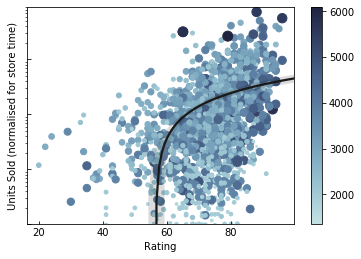

In [138]:
#ax = sns.lmplot("Rating", "Units_Sold", data=ratingVsSold, hue="store_time_days", fit_reg=False)
#ax.set(yscale="log")

min_max_scaler = preprocessing.MinMaxScaler()

points = plt.scatter(ratingVsSold["Rating"], ratingVsSold["Units_Sold"], s = min_max_scaler.fit_transform(ratingVsSold[["store_time_days"]])*100,
                     c=ratingVsSold["store_time_days"], cmap= sns.cubehelix_palette(rot=-.2, as_cmap=True))
plt.colorbar(points)

ax = sns.regplot("Rating", "Units_Sold", data=ratingVsSold, scatter=False, color=".1")
ax.set(yscale="log")
ax.set(ylim=(0.001, 9))
ax.yaxis.set_label_text('Units Sold (normalised for store time)')
ax.set(yticklabels=[])
ax.tick_params(direction="in")

#fig = points.get_figure()
#fig.savefig('UnitsSoldvsRating_Fit.svg')


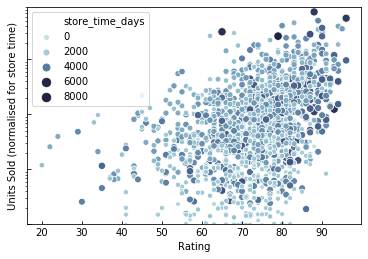

In [63]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="Rating", y="Units_Sold",
                     size = "store_time_days", hue = "store_time_days",
                     palette=cmap,
                     data=ratingVsSold)
ax.set(yscale="log")
ax.set(ylim=(0.001, 9))
ax.yaxis.set_label_text('Units Sold (normalised for store time)')
ax.set(yticklabels=[])
ax.tick_params(direction="in")

fig = ax.get_figure()
fig.savefig('UnitsSoldvsRating.svg') 

Funcion coefficients:
[1.95865095e-05 1.15273023e-01]
Covariance of coefficients:
[[ 1.46265334e-10 -8.52050193e-08]
 [-8.52050193e-08  4.98645434e-05]]


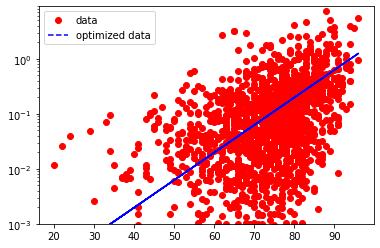

residual sum of squares
365.96286225488535
total sum of squares
416.1850558281619
 r-squared
0.12067274610170708


In [73]:
############ Curve fitting using exponential 

x = ratingVsSold["Rating"].values
y = ratingVsSold["Units_Sold"].values
param, param_cov = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(4, 0.1))

print("Funcion coefficients:") 
print(param) 
print("Covariance of coefficients:") 
print(param_cov)

y_fit = param[0]*np.exp(param[1]*x)


plt.semilogy(x, y, 'o', color ='red', label ="data") 
plt.semilogy(x, y_fit, '--', color ='blue', label ="optimized data") 
plt.legend()

axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0.001, 9])

plt.savefig('ExpFit.svg')
plt.show()





# residual sum of squares
ss_res = np.sum((y - y_fit) ** 2)
# total sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)



print("residual sum of squares") 
print(ss_res) 
print("total sum of squares") 
print(ss_tot)
print(" r-squared") 
print(r2)


In [132]:
### Why is the trend not a good model? Lets have a simple look at some of the outliers 

x_cut1 = x[y<0.125*y_fit]

x_cut2 = x[y>3*y_fit]

below_LOBF = ratingVsSold.loc[x_cut1]
above_LOBF = ratingVsSold.loc[x_cut2]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [133]:
below_LOBF.head()
below_LOBF_stat = below_LOBF.groupby(['genre']).size().reset_index(name='count')
below_LOBF_stat['percentage'] = (below_LOBF_stat['count']/below_LOBF_stat['count'].sum())*100
print(below_LOBF_stat)

        genre  count  percentage
0      Action    314   42.837653
1   Adventure    256   34.924966
2         RPG     10    1.364256
3      Racing      2    0.272851
4  Simulation     30    4.092769
5    Strategy    121   16.507503


In [135]:
above_LOBF.head()
above_LOBF_stat = above_LOBF.groupby(['genre']).size().reset_index(name='count')
above_LOBF_stat['percentage'] = (above_LOBF_stat['count']/above_LOBF_stat['count'].sum())*100
print(above_LOBF_stat)

        genre  count  percentage
0      Action     90   37.656904
1   Adventure     78   32.635983
2         RPG      9    3.765690
3  Simulation      8    3.347280
4    Strategy     54   22.594142


In [136]:
ratingVsSold_stat = ratingVsSold.groupby(['genre']).size().reset_index(name='count')
ratingVsSold_stat['percentage'] = (ratingVsSold_stat['count']/ratingVsSold_stat['count'].sum())*100
print(ratingVsSold_stat)

                    genre  count  percentage
0                  Action    495   24.725275
1               Adventure    639   31.918082
2                  Casual     60    2.997003
3            Early Access      2    0.099900
4                   Indie     58    2.897103
5   Massively Multiplayer     13    0.649351
6                     RPG     56    2.797203
7                  Racing     46    2.297702
8              Simulation    228   11.388611
9                  Sports     21    1.048951
10               Strategy    384   19.180819


In [ ]:
######### Or just linear fit with a log y axis.....

x = ratingVsSold["Rating"][ratingVsSold["Units_Sold"]>0].values
y = np.log10(ratingVsSold["Units_Sold"][ratingVsSold["Units_Sold"]>0].values)
X = sm.add_constant(x) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

plt.plot(x, y, 'o', color ='red', label ="data") 
plt.plot(x, predictions, '--', color ='blue', label ="fit") 
plt.legend()
plt.show()

In [74]:
temptemp = ratingVsSold[ratingVsSold.Rating>85].sort_values(['Units_Sold'], ascending=[False]) 
print(temptemp[temptemp.Units_Sold>0][0:20])
print(appInfo[appInfo['appid'] == 72850])

     appid  Rating  Units_Sold  store_time_days      genre
0      240      88    7.288240             5544     Action
4      220      96    5.598481             5529     Action
2      550      89    5.048879             3703     Action
9    72850      94    4.001678             2979        RPG
22     400      90    3.734064             4471     Action
12     620      95    3.592465             3185  Adventure
16   49520      89    3.508811             2667     Action
3     8930      90    3.139069             3394   Strategy
33     380      87    2.859473             4967     Action
49     420      90    2.627376             4471     Action
20   10180      86    2.390777             3708     Action
21   10190      86    2.390777             3708     Action
25    8870      94    1.860775             2478     Action
40  205100      91    1.845049             2646  Adventure
39  200710      88    1.838964             2664  Adventure
23     500      89    1.829604             4067     Acti